In [ ]:
# Preprocesamiento:
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Modelos
from sklearn.cluster import KMeans


# Métricas
from sklearn.metrics import silhouette_score

## 4.3. Análisis de clustering

### 4.3.1. Preparación del set de datos

<span style="font-size:larger;">
    
Para este análisis tomaremos las siguientes variables en consideración:

**edad**, **trabajo**, **estado_civil**, **educacion**, **deuda**, **saldo**, **vivienda**, **prestamo**, **duracion**, **campaign**, **contactos_anteriores**

    
No se incluyen las columnas "tipo_contacto" y "resultado_campanas_anteriores" por contener demasiados valores nulos.
No se incluyen las columna "fecha_contacto" y "tiempo_transcurrido" por no aportar información relevante en este análisis. (Podría comprobarse en análisis exhaustivo)
</span>

In [216]:
clustering_cols = ["edad", "trabajo", "estado_civil", "educacion", "deuda", "saldo", "vivienda", "prestamo", "duracion", "campaign", "contactos_anteriores"]

In [217]:
data_clustering = data[clustering_cols].copy()

In [218]:
data_clustering.head(3)

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,duracion,campaign,contactos_anteriores
0,40,blue-collar,casado,secundaria/superiores,0,580,1,0,192,1,0
1,47,services,soltero,secundaria/superiores,0,3644,0,0,83,2,0
2,25,student,soltero,universitarios,0,538,1,0,226,1,0


<span style="font-size:larger;">
    
* La columna "educacion" presentaba valores nulos. El tratamiento se tendría que discutir, pudiendo hacerse:
    - Asignar la categoria "desconocida"
    - Imputar con KNN
    
Por simplicidad en nuestro caso elegiremos la primera opción.

</span>

In [219]:
data_clustering["educacion"] = data_clustering["educacion"].fillna("desconocida")

<span style="font-size:larger;">
    
* Hago un encoding a las columnas categoricas:

</span>

In [210]:
def column_encoder(df, columns, encoder, ruta_encoders):
    
    for num, column in enumerate(columns):
        
        data_encoded = encoder.fit_transform(df[[column]]).toarray()
            
        with open(ruta_encoders + f"{num}_{column}_encoder.pickle", 'wb') as archivo:
            pickle.dump(encoder, archivo)
            
        df_encoded = pd.DataFrame(data_encoded, columns= encoder.categories_[0].tolist())
        df = pd.concat([df, df_encoded], axis=1).drop([column], axis=1)
        
    return df

In [220]:
ruta_encoders = "utiles/encoders/"
encoded_columns = ["trabajo", "estado_civil", "educacion"]
encoder = OneHotEncoder()

In [221]:
data_clustering = column_encoder(data_clustering, encoded_columns, encoder, ruta_encoders)

In [222]:
data_clustering.head(1)

,edad,deuda,saldo,vivienda,prestamo,duracion,campaign,contactos_anteriores,admin.,blue-collar,...,technician,unemployed,unknown,casado,divorciado,soltero,desconocida,priamaria,secundaria/superiores,universitarios
0,40,0,580,1,0,192,1,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 7.2. K-Means Clustering

<span style="font-size:larger;">

K-Means es un algoritmo de aprendizaje no supervisado que tiene como objetivo agrupar observaciones en un conjunto de datos en diferentes clústeres. Dado que nuestro objetivo es identificar los diferentes grupos a los que pertenecen los clientes, intentaremos encontrar el número de clústeres que mejor se adapte a nuestros datos.
    
</span>

In [176]:
def kmeans_inertia(k, X):
        '''
    Fits a KMeans model for different values of k.
    Calculates an inertia score for each k value.

    Args:
        k: (list of ints) - The different k values to try
        X: (array) - The training data         

    Returns: 
        inertia: (list) - A list of inertia scores, one for each value of k
    '''
        
        inertia = []
        
        for i in k:
            kms = KMeans(n_clusters = i, random_state = 42)
            kms.fit(X)            
            inertia.append(kms.inertia_)
        
        return inertia
    
def kmeans_sil(k, X):
    '''
    Fits a KMeans model for different values of k.
    Calculates a silhouette score for each k value

    Args:
        k: (list of ints) - The different k values to try
        X: (array) - The training data

    Returns: 
        sil_scores: (list) - A list of silhouette scores, one for each value of k
    '''
    
    sil_scores = []
    
    for i in k:
        kms = KMeans(n_clusters = i, random_state = 42)
        kms.fit(X)
        sil_scores.append(silhouette_score(X, kms.labels_))
        
    return sil_scores

In [225]:
num_clusters = [i for i in range(2, 11)]

Inertia_log = kmeans_inertia(num_clusters, data_clustering)

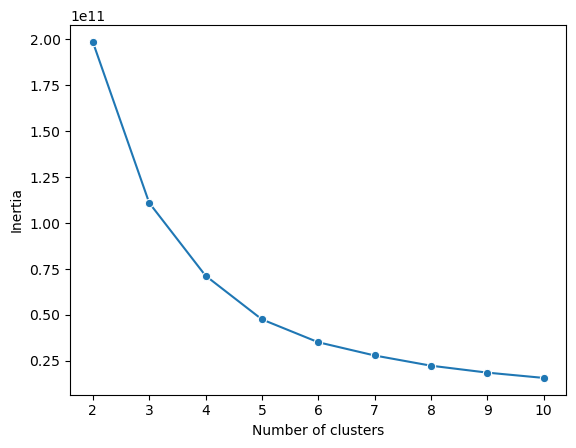

In [226]:
plot = sns.lineplot(x=num_clusters, y=Inertia_log, marker = "o")
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

<span style="font-size:larger;">


El codo no está claro, pero parece estar en tres clusters. Vamos a verificarlo con el Silhouette score.<br>

El Silhouette score proporciona información sobre cuál debería ser el valor óptimo para k, y utiliza tanto medidas intraclúster como interclúster en sus cálculos.
    
</span>

In [227]:
sil_scores = kmeans_sil(num_clusters, data_clustering)

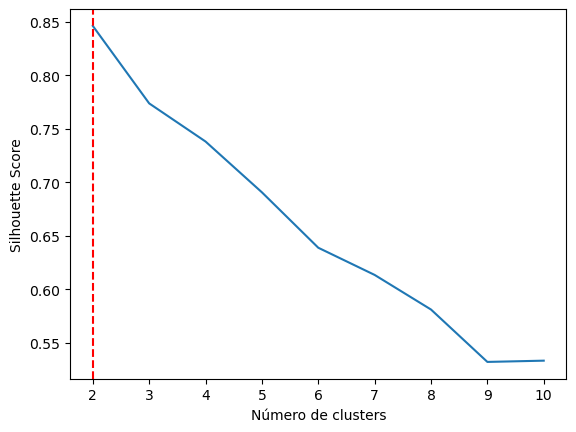

In [228]:
plot = sns.lineplot(x=num_clusters, y=sil_scores)
plot.axvline(x=2, color="red", linestyle="--")
plot.set_xlabel("Número de clusters");
plot.set_ylabel("Silhouette Score");

<span style="font-size:larger;">
    
Está más cerca del 1 los dos clusters. Serían dos grupos.
    
Empiezo probando con 3 aún así.

</span>

In [229]:
KMeans_3 = KMeans(n_clusters=3, random_state=42)
KMeans_3.fit(data_clustering)

KMeans(n_clusters=3, random_state=42)

In [231]:
df_centroides  = pd.DataFrame(data = KMeans_3.cluster_centers_, columns = data_clustering.columns)
df_centroides

,edad,deuda,saldo,vivienda,prestamo,duracion,campaign,contactos_anteriores,admin.,blue-collar,...,technician,unemployed,unknown,casado,divorciado,soltero,desconocida,priamaria,secundaria/superiores,universitarios
0,40.627715,0.020081,641.215646,0.564676,0.169740,256.459763,2.771403,0.569463,0.116982,0.220635,...,0.169186,0.028370,0.006072,0.598035,0.117385,0.284580,0.040111,0.152356,0.523558,0.283976
1,43.461394,0.000235,6339.637174,0.486506,0.082610,275.771650,2.665337,0.697724,0.096222,0.172729,...,0.161699,0.032152,0.008214,0.637878,0.096691,0.265431,0.048111,0.149495,0.429007,0.373387
2,45.606557,0.003279,25539.449180,0.400000,0.055738,256.718033,2.744262,0.537705,0.075410,0.085246,...,0.104918,0.036066,0.013115,0.649180,0.104918,0.245902,0.042623,0.078689,0.344262,0.534426


In [235]:
data_clus = data.copy()

In [236]:
data_clus["cluster"] = KMeans_3.labels_

In [243]:
data_clus.groupby("cluster")["trabajo"].value_counts()

cluster  trabajo      
0        blue-collar      8757
         management       7992
         technician       6713
         admin.           4643
         services         3759
         retired          1879
         self-employed    1364
         entrepreneur     1311
         unemployed       1126
         housemaid        1077
         student           826
         unknown           241
1        management       1154
         blue-collar       736
         technician        691
         admin.            410
         retired           308
         services          288
         self-employed     167
         unemployed        137
         housemaid         129
         entrepreneur      116
         student            92
         unknown            35
2        management        117
         technician         32
         retired            30
         blue-collar        26
         admin.             23
         entrepreneur       23
         self-employed      17
         unemplo

# GradientboostingClassifier

# Con columnas imp

In [90]:
X_data_imp_cols = X_balanceado[best_cols]
y_data_imp_cols = y_balanceado.copy()

X_train, X_test, y_train, y_test = train_test_split(X_data_imp_cols, y_data_imp_cols, test_size=0.2, random_state=42, stratify= y_data_imp_cols)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35943, 24), y_train: (35943,)
X_test: (8986, 24), y_test: (8986,)


In [91]:
model_GBC = GradientBoostingClassifier(random_state=42)

scorer = ["accuracy"]

params = {"n_estimators"         : [100],
          "criterion"            : ['friedman_mse'],
          "subsample"            : [1],
          "max_depth"            : [3],
          "max_features"         : [None],
          "max_leaf_nodes"       : [None],
          "min_impurity_decrease": [0],
          "min_samples_split"    : [2],
          "loss"                 : ['log_loss'],
          "learning_rate"        : [0.1]
         }

resultados_tuning_GBC = tunning(model_GBC, params, scorer, X_train, X_test, y_train, y_test)

In [92]:
resultados_tuning_GBC[["Nombre", "Accuracy", "Precision", "Recall"]]

,Nombre,Accuracy,Precision,Recall
0,GradientBoostingClassifier,0.894836,0.6457,0.429181


In [69]:
resultados_tuning_GBC[["Nombre", "Accuracy", "Precision", "Recall"]]

,Nombre,Accuracy,Precision,Recall
0,GradientBoostingClassifier,0.894169,0.643693,0.422355


In [612]:
# balanceado
resultados_tuning_GBC[["Nombre", "Accuracy", "Precision", "Recall"]]

,Nombre,Accuracy,Precision,Recall
0,GradientBoostingClassifier,0.895294,0.549479,0.419483
